In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("class_data.csv")
df.head()

,Unnamed: 0,LS_type,DA_area,prob_inh,prob_dyn,slope_tan,elevation,curvature,aspect,wet_index,litho,lulc
0,5590629,0,3.0,0.0222,0.000,0.590219,1187.2250,0.032023,0.808429,5.473453,3.0,41.0
1,6890003,0,3.0,0.0156,0.140,1.238201,1215.5310,0.681722,11.066680,4.919455,6.0,41.0
2,1668619,0,3.0,0.0304,0.000,0.504280,920.3857,0.960537,105.222600,5.267390,5.0,41.0
3,2848326,0,3.0,0.0958,0.000,0.528550,850.8190,-0.689792,272.803000,7.695759,1.0,41.0
4,1870080,0,3.0,0.0404,0.004,0.635189,1645.8110,0.965224,103.165300,6.052179,5.0,52.0


In [120]:
df.drop(df.columns[0], axis=1, inplace = True)

In [121]:
from sklearn.preprocessing import OneHotEncoder

labels = ['1','3','4','5','6','7']

gen_ohe = OneHotEncoder()
gen_feature_arr = gen_ohe.fit_transform(
                              df[['litho']]).toarray()
gen_feature_labels = labels
gen_features = pd.DataFrame(gen_feature_arr, 
                            columns=gen_feature_labels)

df = pd.concat([df, gen_features], axis=1)

In [122]:
bins = [0,.65,.85,4]
labels = [1,2,3]
df['slope_bin'] = pd.cut(df['slope_tan'], bins, labels = labels)

df['slope_bin'] = df['slope_bin'].astype('int64')

In [123]:
bins = [0,90,180,270,360]
#labels = ['NE','SE','SW','NW']
labels = ['1','2','3','4']
df['aspect_bin'] = pd.cut(df['aspect'], bins = bins, labels = labels)

df['aspect_bin'] = df['aspect_bin'].astype('int64')

In [124]:
aspect_dummy_features = pd.get_dummies(df['aspect_bin'])
df = pd.concat([df, aspect_dummy_features], 
          axis=1)

In [125]:
LU_dummy_features = pd.get_dummies(df['lulc'], prefix='LU')
df = pd.concat([df, LU_dummy_features], 
          axis=1)

In [126]:
DA_dummy_features = pd.get_dummies(df['DA_area'], prefix = 'DA')
df = pd.concat([df, DA_dummy_features], 
          axis=1)

In [127]:
df['prob_inh_log'] = np.log(df['prob_inh'])

In [128]:
df['slope_log'] = np.log(df['slope_tan'])

In [129]:
df.head()

,LS_type,DA_area,prob_inh,prob_dyn,slope_tan,elevation,curvature,aspect,wet_index,litho,...,LU_21.0,LU_31.0,LU_41.0,LU_52.0,LU_71.0,DA_1.0,DA_2.0,DA_3.0,prob_inh_log,slope_log
0,0,3.0,0.0222,0.000,0.590219,1187.2250,0.032023,0.808429,5.473453,3.0,...,0,0,1,0,0,0,0,1,-3.807663,-0.527262
1,0,3.0,0.0156,0.140,1.238201,1215.5310,0.681722,11.066680,4.919455,6.0,...,0,0,1,0,0,0,0,1,-4.160484,0.213660
2,0,3.0,0.0304,0.000,0.504280,920.3857,0.960537,105.222600,5.267390,5.0,...,0,0,1,0,0,0,0,1,-3.493313,-0.684623
3,0,3.0,0.0958,0.000,0.528550,850.8190,-0.689792,272.803000,7.695759,1.0,...,0,0,1,0,0,0,0,1,-2.345493,-0.637618
4,0,3.0,0.0404,0.004,0.635189,1645.8110,0.965224,103.165300,6.052179,5.0,...,0,0,0,1,0,0,0,1,-3.208925,-0.453833


In [130]:
#splitting dep and ind vars 'prob_dyn','NW',
y = pd.DataFrame(df['LS_type'])
#Model for logistic regression and SVM
X = df[['prob_inh_log','slope_bin','wet_index','LU_31.0','LU_41.0','LU_52.0',
    'LU_71.0','1','SE','SW','DA_3.0']]

#Model for trees and forests
#X = df[['DA_area','prob_inh','prob_dyn','slope_bin','elevation','curvature','aspect_bin','litho','lulc']]

In [132]:
#splitting training and test data
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [133]:
#Oversampling - comment out if decide not to oversample
from imblearn import over_sampling

# define oversampling strategy
oversample = over_sampling.SMOTE(sampling_strategy = .5, random_state=20)

X_train, y_train = oversample.fit_resample(X_train, y_train)

# Decision Tree

[0.87855946 0.87939698 0.88902848 0.91247906 0.92085427 0.92671692
 0.93551089 0.93718593 0.95100503 0.98450586]
[0.8925 0.8425 0.855  0.8575 0.8675 0.86   0.86   0.8475 0.8625 0.84  ]


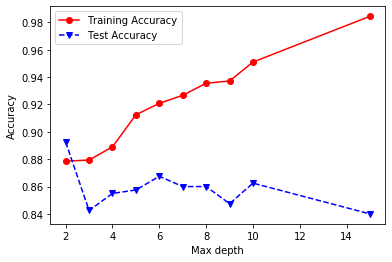

In [136]:
from sklearn.metrics import accuracy_score

maxdepths = [2,3,4,5,6,7,8,9,10,15]

trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=depth)
    clf = clf.fit(X_train, y_train)
    y_predTrain = clf.predict(X_train)
    y_predTest = clf.predict(X_test)
    trainAcc[index] = accuracy_score(y_train, y_predTrain)
    testAcc[index] = accuracy_score(y_test, y_predTest)
    index += 1
    
#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(maxdepths,trainAcc,'ro-',maxdepths,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

print(trainAcc)
print(testAcc)

In [89]:
d = {'train': trainAcc, 'test': testAcc}
pd.DataFrame(d, columns=['train','test'])

,train,test
0,0.896706,0.8925
1,0.896706,0.8925
2,0.896706,0.8925
3,0.900614,0.8850
4,0.908431,0.8900
5,0.914573,0.8600
6,0.924065,0.8700
7,0.932998,0.8600
8,0.941374,0.8525
9,0.986041,0.8500


In [90]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf = clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train) 
y_pred_test = clf.predict(X_test)

precision  = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print("training data prediction accuracy:", "%.3f" %accuracy_score(y_train, y_pred_train))
print("testing data prediction accuracy:", "%.3f" %accuracy_score(y_test, y_pred_test))
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

training data prediction accuracy: 0.897
testing data prediction accuracy: 0.892
Precision: 1.000
Recall: 0.543


In [91]:
#Comparing actual and predicted results
tree = pd.DataFrame(y_pred_test, columns=['predicted'])
tree = tree.assign(actual=y_test.values)
tree["diff"] = tree["predicted"] - tree['actual']
tree['pred_category'] = [1 if x > 0.5 else 0 for x in tree['predicted']]
print(tree)

     predicted  actual  diff  pred_category
0            1       1     0              1
1            0       1    -1              0
2            0       1    -1              0
3            1       1     0              1
4            0       0     0              0
..         ...     ...   ...            ...
395          0       0     0              0
396          1       1     0              1
397          0       0     0              0
398          0       0     0              0
399          0       0     0              0

[400 rows x 4 columns]


In [92]:
#Confusion Matrix
pd.crosstab([tree['actual']],tree['pred_category'])

pred_category,0,1
actual,,
0,306,0
1,43,51


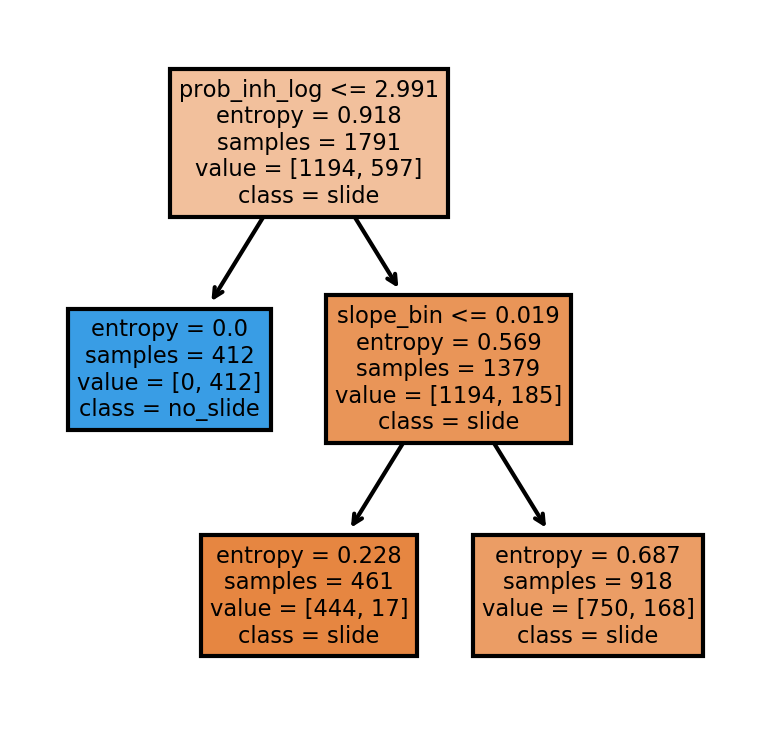

In [94]:
from sklearn import tree

fn=['prob_inh_log','slope_bin','wet_index','LU_31.0','LU_41.0','LU_52.0',
     'LU_71.0','1','SE','SW','DA_3.0']
cn=['slide','no_slide']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True)

#plt.savefig("tree")

# Logistic Regression

In [853]:
from sklearn import linear_model

clf2 = make_pipeline(StandardScaler(), linear_model.LogisticRegression(penalty='none'))
clf2.fit(X_train, y_train.values.ravel())
y_pred_train = clf2.predict(X_train)
y_pred_test = clf2.predict(X_test)

precision  = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print("training data prediction accuracy:", "%.3f" %accuracy_score(y_train, y_pred_train))
print("testing data prediction accuracy:", "%.3f" %accuracy_score(y_test, y_pred_test))
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

training data prediction accuracy: 0.878
testing data prediction accuracy: 0.897
Precision: 0.908
Recall: 0.628


In [854]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())
margeff = logit_res.get_margeff()
print(margeff.summary())

                           Logit Regression Results                           
Dep. Variable:                LS_type   No. Observations:                 1791
Model:                          Logit   Df Residuals:                     1780
Method:                           MLE   Df Model:                           10
Date:                Mon, 18 May 2020   Pseudo R-squ.:                  0.5104
Time:                        21:53:42   Log-Likelihood:                -558.09
converged:                       True   LL-Null:                       -1140.0
Covariance Type:            nonrobust   LLR p-value:                9.223e-244
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
prob_inh_log    -0.7579      0.183     -4.151      0.000      -1.116      -0.400
slope_bin       -0.8573      0.136     -6.288      0.000      -1.125      -0.590
wet_index        0.1900      0.058      3.28

In [856]:
#Comparing actual and predicted results
df1 = pd.DataFrame(y_pred_test, columns=['predicted'])
df1 = df1.assign(actual=y_test.values)
df1["diff"] = df1["predicted"] - df1['actual']
df1['pred_category'] = [1 if x > 0.5 else 0 for x in df1['predicted']]
print(df1)

     predicted  actual      diff  pred_category
0     0.996168       1 -0.003832              1
1     0.130827       1 -0.869173              0
2     0.225091       1 -0.774909              0
3     0.954635       1 -0.045365              1
4     0.171538       0  0.171538              0
..         ...     ...       ...            ...
395   0.303593       0  0.303593              0
396   0.986992       1 -0.013008              1
397   0.225492       0  0.225492              0
398   0.092989       0  0.092989              0
399   0.053652       0  0.053652              0

[400 rows x 4 columns]


In [857]:
#Confusion Matrix
pd.crosstab([df1['actual']],df1['pred_category'])

pred_category,0,1
actual,,
0,299,7
1,40,54


Text(0, 0.5, 'predicted y - actual y')

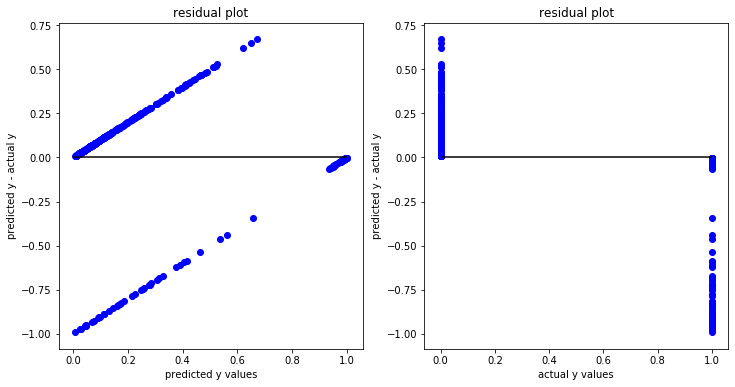

In [858]:
#Residual plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.scatter(df1["predicted"], (df1["predicted"] - df1['actual']), c='b')
ax1.hlines(y=0, xmin= 0, xmax=1)
ax1.set_title('residual plot')
ax1.set_xlabel('predicted y values')
ax1.set_ylabel('predicted y - actual y')

ax2.scatter(df1["actual"], (df1["predicted"] - df1['actual']), c='b')
ax2.hlines(y=0, xmin= 0, xmax=1)
ax2.set_title('residual plot')
ax2.set_xlabel('actual y values')
ax2.set_ylabel('predicted y - actual y')

# SVM

Text(0, 0.5, 'Accuracy')

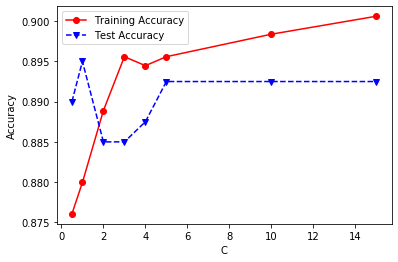

In [859]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

C = [.5,1,2,3,4,5,10,15]
SVMtrainAcc = []
SVMtestAcc = []

for param in C:
    clf = make_pipeline(StandardScaler(), SVC(C=param,kernel='rbf',gamma='auto'))
    clf.fit(X_train, y_train.values.ravel())
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    SVMtrainAcc.append(accuracy_score(y_train, y_pred_train))
    SVMtestAcc.append(accuracy_score(y_test, y_pred_test))

plt.plot(C, SVMtrainAcc, 'ro-', C, SVMtestAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('C')
plt.ylabel('Accuracy')

In [870]:
clf = make_pipeline(StandardScaler(), SVC(C=1,kernel='rbf',gamma='auto'))
clf.fit(X_train, y_train.values.ravel())
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

precision  = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print("training data prediction accuracy:", "%.3f" %accuracy_score(y_train, y_pred_train))
print("testing data prediction accuracy:", "%.3f" %accuracy_score(y_test, y_pred_test))
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

training data prediction accuracy: 0.880
testing data prediction accuracy: 0.895
Precision: 0.981
Recall: 0.564


In [871]:
#Comparing actual and predicted results
svmdf = pd.DataFrame(y_pred_test, columns=['predicted'])
svmdf = svmdf.assign(actual=y_test.values)
svmdf["diff"] = svmdf["predicted"] - svmdf['actual']
svmdf['pred_category'] = [1 if x > 0.5 else 0 for x in svmdf['predicted']]
print(svmdf)

     predicted  actual  diff  pred_category
0            1       1     0              1
1            0       1    -1              0
2            0       1    -1              0
3            1       1     0              1
4            0       0     0              0
..         ...     ...   ...            ...
395          0       0     0              0
396          1       1     0              1
397          0       0     0              0
398          0       0     0              0
399          0       0     0              0

[400 rows x 4 columns]


In [872]:
pd.crosstab([svmdf['actual']],svmdf['pred_category'])

pred_category,0,1
actual,,
0,305,1
1,41,53


# Random Forest

In [134]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier

numBaseClassifiers = 500
maxdepth = 1
trainAcc = []
testAcc = []
prec = []
recall = []

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(X_train, y_train.values.ravel())
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

#Scores
trainAcc.append(accuracy_score(y_train, y_pred_train))
testAcc.append(accuracy_score(y_test, y_pred_test))
prec.append(precision_score(y_test, y_pred_test))
recall.append(recall_score(y_test, y_pred_test))

print("train:", trainAcc)
print("test:", testAcc)
print("precision", prec)
print("recall", recall)

train: [1.0]
test: [0.895]
precision [0.9193548387096774]
recall [0.6063829787234043]


In [135]:
clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, y_train.values.ravel())
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9489112227805695
0.8725


In [117]:
#Comparing actual and predicted results
df1 = pd.DataFrame(y_pred_test, columns=['predicted'])
df1 = df1.assign(actual=y_test.values)
df1["diff"] = df1["predicted"] - df1['actual']
df1['pred_category'] = [1 if x > 0.5 else 0 for x in df1['predicted']]
print(df1)

     predicted  actual  diff  pred_category
0            1       1     0              1
1            0       1    -1              0
2            0       1    -1              0
3            1       1     0              1
4            0       0     0              0
..         ...     ...   ...            ...
395          0       0     0              0
396          1       1     0              1
397          0       0     0              0
398          0       0     0              0
399          0       0     0              0

[400 rows x 4 columns]


In [118]:
#Confusion Matrix
pd.crosstab([df1['actual']],df1['pred_category'])

pred_category,0,1
actual,,
0,295,11
1,38,56
